## Import libraries, load ASR function, unzip dataset, and download model

In [ ]:
!pip install -r requirements.txt

In [1]:
import os
import transformers
import torchaudio
import numpy as np
import sentencepiece
import csv
import pandas as pd

from pyctcdecode import build_ctcdecoder
from transformers import Wav2Vec2ProcessorWithLM, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, AutoTokenizer, AutoModelForSeq2SeqLM
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

This function performs text generation from audio files in wav format.
It loads the audio file into an array, adjust the sample rate to the one required by the model (16000) and run it into the model that generates text from the waveform.

In [2]:
def asr_model(wav_file, model, processor):
    waveform, sample_rate = torchaudio.load(wav_file)
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000, resampling_method='sinc_interpolation')
    # Downsampling is required to match the model's frequency, i.e.
    # the frequency of the dataset the model was trained on.
    speech_array = resampler(waveform).squeeze().numpy()
    inputs = processor(speech_array, sampling_rate=16000, return_tensors="pt")['input_values']
    # Detach the tensors first (otherwise, they require gradients
    # to be computed); also, since we're simulating the inference
    # squeeze the resulting array at the first dimension (batch_size),
    # otherwise, leave it as is, and call batch_decode() instead.
    outputs = model(inputs)['logits'].detach().numpy().squeeze(0)
    return(processor.decode(outputs).text)

Download model and processor to be used in the function above.

In [3]:
model = Wav2Vec2ForCTC.from_pretrained("Yehor/wav2vec2-xls-r-300m-uk-with-small-lm")

In [4]:
processor = Wav2Vec2ProcessorWithLM.from_pretrained("Yehor/wav2vec2-xls-r-300m-uk-with-small-lm")

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'snapshot_download': allow_regex. Will not be supported from version '0.12'.

Please use `allow_patterns` and `ignore_patterns` instead.
  warnings.warn(message, FutureWarning)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading the LM will be faster if you build a binary file.
Reading /home/studio-lab-user/.cache/pyctcdecode/models--Yehor--wav2vec2-xls-r-300m-uk-with-small-lm/snapshots/bbd936400e7566ba44560440aa4abd05b5983c17/language_model/5gram_correct.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


In [14]:
# Unzip file
!unzip INTER.zip

Archive:  INTER.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of INTER.zip or
        INTER.zip.zip, and cannot find INTER.zip.ZIP, period.


## Prepare dataset

After extracting the files, change directory to the files location. List all the directories in the location to access the files from them.

In [5]:
# Save list of directories in the dataset folder

%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/INTER'

folders = os.listdir()
folders = folders[:-1]

/home/studio-lab-user/sagemaker-studiolab-notebooks/INTER


Create a variable to store the file paths and their corresponding transcripts. The variable is a list containing sublists for each pair if path and transcript.
Then, open the file in each directory of the list created before. For each line of the opened file, remove the '/' in the beginning of the line, to keep the path in the appropriate format. In this dataset, the paths and transcripts are separated by two spaces, so a string containing two spaces is used to split the line into a list containing those two elements.

In [6]:
# Open text files in the dataset folders and save each row in a list (splitting the file path and the transcription into an inner list)
text = []
for f in folders:
    file = open(f+'/etc/txt.done.data', 'r', encoding='utf8')
    for line in file:
        line = line.lstrip('/')
        text.append(line.split('  '))

Check if the path and the transcript were splitted correctly by printing the first line. Check if the length of the list matches the size of the dataset (number of wav files).

In [7]:
print(text[0])

['INTER/16144517608610/wav/spk_id_10294_16144517950804.wav', 'тільки за минулий рік\n']


In [8]:
print(len(text))

15906


## Generate text

Change the working directory again to create a csv file that will store all the paths, transcripts, and generated text from the ASR model. The file creation is done in a separate cell because it writes a header to the file, this way the header is not written again when re-running the cell to append more sentences.

In [10]:
%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/'

/home/studio-lab-user/sagemaker-studiolab-notebooks


In [11]:
# Create csv file with header

with open('inter_transcription_generated-text.csv', 'w', encoding='UTF8', newline='\n') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(['path', 'transcription', 'generated_text'])

The loop below calls the function to generate text. The output is saved into a variable that is appended to the list containing the path and transcript for the sentence.
Lastly, the sublist corresponding to the sentence, containing path + transcript + generated text, is written as a new line into the file created earlier.

PS.: the option to write one line at a time to the file was made because with large datasets, the notebook can crash for a number or reasons. When this happens, this cell can be re-run from where it stopped by replacing the 0 that sets the initial range in the for loop with the number of the last line written to the file (and not the last line, since the range starts at 0 and the lines in the file are counted from 1). Otherwise, the content appended to the text variable would have been lost.

In [12]:
# Append generated text in the list and save to csv file
for i in range(9338, len(text)):
    gen_text = asr_model(text[i][0], model, processor)
    text[i].append(gen_text)

    with open('inter_transcription_generated-text.csv', 'a', encoding='UTF8', newline='\n') as f:
        writer = csv.writer(f)

        # write the data
        writer.writerows(text[i:i+1])

## Length Classification

Load the csv containing the wav path, transcript, and generated text as a pandas dataframe.

In [16]:
transcripts = pd.read_csv("inter_transcription_generated-text2.csv", encoding='utf-8')

In [17]:
transcripts.head()

,path,transcription,generated_text
0,INTER/16144517608610/wav/spk_id_10294_16144517...,тільки за минулий рік\n,тільки за минули ріг
1,INTER/16144517608610/wav/spk_id_10294_16144517...,звільнили\n,звільнили
2,INTER/16144517608610/wav/spk_id_10294_16144517...,майже п'ять тисяч своїх працівників повідомили\n,майже п'ять тисяч своїх працівників повідомили
3,INTER/16144517608610/wav/spk_id_10294_16144517...,найбільше людей втратили роботу\n,найбільше людей втратила роботу в
4,INTER/16144517608610/wav/spk_id_10294_16144517...,скорочення\n,скорочення


To calculate the length difference between the transcript and the generated text, first remove the newline character, if it is present in the transcript. Then, subtract the length of the generated text from the transcript length. Append the result to a list and save the list as a column in the dataframe.

In [18]:
# Calculate length difference between transcripts
length = []
for i in range(len(transcripts['path'])):
    transcripts['transcription'][i] = transcripts['transcription'][i].rstrip('\n')
    length.append(len(transcripts['transcription'][i]) - len(transcripts['generated_text'][i]))

In [19]:
# Create column in dataset
transcripts['length_diff'] = length
transcripts.head()

,path,transcription,generated_text,length_diff
0,INTER/16144517608610/wav/spk_id_10294_16144517...,тільки за минулий рік,тільки за минули ріг,1
1,INTER/16144517608610/wav/spk_id_10294_16144517...,звільнили,звільнили,0
2,INTER/16144517608610/wav/spk_id_10294_16144517...,майже п'ять тисяч своїх працівників повідомили,майже п'ять тисяч своїх працівників повідомили,0
3,INTER/16144517608610/wav/spk_id_10294_16144517...,найбільше людей втратили роботу,найбільше людей втратила роботу в,-2
4,INTER/16144517608610/wav/spk_id_10294_16144517...,скорочення,скорочення,0


Based on the difference, classificate each transcript into one of three categories: incomplete (difference is equal or less than -10), inconclusive (difference is equal to or less than -5), or complete (difference is greater than -5). Save the classification as a new column of the dataframe and then save the dataframe as a csv file.

In [21]:
# Classificate transcripts according to length difference

transcripts['length_cat'] = [0 for x in range(15906)]

for i in range(len(transcripts['length_diff'])):
  if transcripts['length_diff'][i] <= -10:
    transcripts['length_cat'][i] = 'incomplete'
  elif transcripts['length_diff'][i] <= -5:
    transcripts['length_cat'][i] = 'inconclusive'
  else:
    transcripts['length_cat'][i] = 'complete'
    

transcripts.to_csv('transcripts_length_cat_inter.csv', encoding='utf-8')
transcripts.head()

/tmp/ipykernel_502/944441250.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts['length_cat'][i] = 'complete'


,path,transcription,generated_text,length_diff,length_cat
0,INTER/16144517608610/wav/spk_id_10294_16144517...,тільки за минулий рік,тільки за минули ріг,1,complete
1,INTER/16144517608610/wav/spk_id_10294_16144517...,звільнили,звільнили,0,complete
2,INTER/16144517608610/wav/spk_id_10294_16144517...,майже п'ять тисяч своїх працівників повідомили,майже п'ять тисяч своїх працівників повідомили,0,complete
3,INTER/16144517608610/wav/spk_id_10294_16144517...,найбільше людей втратили роботу,найбільше людей втратила роботу в,-2,complete
4,INTER/16144517608610/wav/spk_id_10294_16144517...,скорочення,скорочення,0,complete


To have a picture about the completeness of the transcripts, count and plot the values in each category.

In [22]:
# Count n of transcripts per category
transcripts['length_cat'].value_counts()

complete        12889
incomplete       2353
inconclusive      664
Name: length_cat, dtype: int64

<AxesSubplot: >

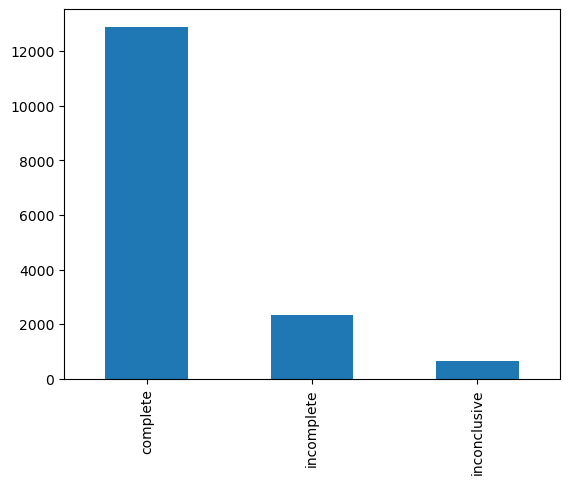

In [23]:
transcripts['length_cat'].value_counts().plot.bar()

Finally, select only the transcripts classificated as incomplete or inconclusive and save them into a text file for manual inspection. The text file contains the path, the transcript, and the generated text, each in a different line, with a blank line separating each sentence.

In [24]:
# Select only transcripts in the incomplete and inconclusive categories
txt = transcripts.loc[(transcripts['length_cat'] == 'incomplete') | (transcripts['length_cat'] == 'inconclusive')]
txt.head()

,path,transcription,generated_text,length_diff,length_cat
5,INTER/16144517608610/wav/spk_id_10294_16144517...,штатів цього,штатів продовжуються й цього,-16,incomplete
10,INTER/16144517608610/wav/spk_id_10143_16144517...,ніж квартири,ніж одно кімнатної квартири,-15,incomplete
13,INTER/16144517608610/wav/spk_id_10952_16144517...,помешкання площею від шести квадратних метрів ...,помешкання площуювід шести квадратних метрів к...,-8,inconclusive
36,INTER/16144517823019/wav/spk_id_10381_16144518...,днями затримала,днями кіберполіція затримала,-13,incomplete
43,INTER/16144517823019/wav/spk_id_9419_161445182...,тлі європейці,тлі пандемії європейці,-9,inconclusive


In [25]:
# Save in a text file
with open('transcripts_inter.txt', 'w', encoding='utf-8') as f:
    for t in range(len(txt)):
        f.write(txt.iloc[t,0]+'\n')
        f.write(txt.iloc[t,1]+'\n')
        f.write(txt.iloc[t,2]+'\n')
        f.write('\n\n')